# Plot the PSD (power/freq) of periods of interest 

Plot Baseline, Pre-ictal and Post-ictal periods

In [15]:
import os
import glob
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.signal import spectrogram
from matplotlib.colors import Normalize
from matplotlib.pyplot import cm
from scipy.io import savemat, loadmat
import scipy.stats as stats

%cd /media/Projects/Adrian/seizureProcessing/
from seizureProcessing.utils.readMatfile import *

/media/Projects/Adrian/seizureProcessing


In [2]:
def get_sddata_from_dataframes(path_to_df, fext='.pkl',exclude_str=False):
    
    files = glob.glob(os.path.join(path_to_df,f'*{fext}'))
    
    if exclude_str:
        data_df = pd.concat([pd.read_pickle(fp) for fp in files if exclude_str not in fp],
                            ignore_index=True)
    else:
        data_df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    
    #1) convert dataframe columns to numeric
    COLS_TO_CONVERT = ['sf', 'SO_sec', 'seizureinvaded', 'SO_index', 'sdinvaded_ch',
                     'sdonset_sec', 'sdend_sec', 'sdinvaded_region', 'seizuretermination_sec']
    
    for col in COLS_TO_CONVERT:
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce').fillna(0)
    
    #2) filter data by seizure and SD invaded
    szinvaded_index = data_df.index[data_df['seizureinvaded']==1]
    sdinvaded_index = data_df.index[(data_df['seizureinvaded']==1)&(data_df['sdinvaded_region']==1)]
    nonsdinvaded_index = data_df.index[(data_df['seizureinvaded']==1)&(data_df['sdinvaded_region']==0)]
    return data_df, szinvaded_index, sdinvaded_index, nonsdinvaded_index

In [19]:
def plot_period_hist_mean(ax, data_to_plot, log=False):
    '''plots period of interest, heatmap over samples
    and mean/std line
    '''
    cmap = cm.Blues

    # idea taken from http://stackoverflow.com/a/14779462
    cmaplist = [cmap(i) for i in range(int(cmap.N/4), cmap.N)]
    # set first color to white
    cmaplist[0] = (1, 1, 1, 1)
    # set last color to black
    cmaplist[-1] = (0, 0, 0, 1)

    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    #spDisplayBorder = 5  # µV additional border in display
    
    max_val = np.max([i.max() for i in data_to_plot])
    min_val = np.min([i.min() for i in data_to_plot])

    bins = np.linspace(min_val, max_val, int(round(5*max_val)))

    if bins.shape[0] < 3:
        bins = np.linspace(min_val, max_val, 3)

    nsamp = data_to_plot.shape[1]

    xax = range(nsamp)

    imdata = np.zeros((len(bins) - 1, nsamp))

    for col in range(nsamp):
        #print(col)
        #data_to_plot[:,col]
        data = np.histogram(data_to_plot[:, col], bins=bins)[0]

        if log:
            imdata[:, col] = np.log(1 + data)
        else:
            imdata[:, col] = data

    ydiff = (bins[1] - bins[0])/2.
    extent = [xax[0], xax[-1], min_val-ydiff, max_val-ydiff]


    ax.imshow(imdata,
              cmap=cmap,
              interpolation='hanning',
              aspect='auto',
              origin='lower',
              extent=extent)

    datamean = data_to_plot.mean(0)
    datastd = data_to_plot.std(0)


    ax.plot(xax, datamean, 'k', lw=3)
    ax.plot(xax, datamean + datastd, color='k', lw=1)
    ax.plot(xax, datamean - datastd, color='k', lw=1)

    ax.set_xlim((xax[0], xax[-1]))
    
    return datamean, datastd

In [6]:
def from_micro_to_macro_names_new(micro_list, suffix=False):
    '''transforms a list of micro channel names
    into macro channel names
    
    PARAMETERS:
    micro_list : list/np.array, list of str with 
                channel/file names 
    suffix = bool, True for appending .ncs to names
             default is False
    
    OUTPUT:
    macro_list : list, list of strings with
                 converted names
    '''
    
    NCS = '.ncs'
    
    #get rid of .ncs bit
    micro_list = [x.strip(NCS) for x in micro_list]
    
    macro_list = [] #initializing empty list
    
    #convert names
    for st in micro_list:
        #print(st)
        head = st.rstrip('0123456789')
        tail = st[len(head):]
        lowercase = [x for x in range(len(st)) if st[x].islower()]
        lowercase = lowercase[0] if len(lowercase) else ''
        #print(lowercase, head[])
        if isinstance(lowercase, int):
            head = head[:lowercase]
            lowercase = st[lowercase]

        nhead = head.lstrip('RL')
        ntail = head[:-len(nhead)]


        macroname = nhead+ntail+lowercase+tail
        
        #print(st, macroname)

        if suffix:
            macro_list.append(macroname+NCS)
        else:
            macro_list.append(macroname)

    return macro_list

# Import dataframes with data

In [59]:
dpath = '/media/Seizures/Wenzel/dataframes_patpool/'
data_df, szinv, sdinv, nonsdinv = get_sddata_from_dataframes(dpath, exclude_str='100')
invaded_df = data_df.loc[szinv]

data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
invaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_df['sdinvaded_region'] = pd.to_numeric(data_df['sdinvaded_region'], errors='coerce').fillna(0)
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

sdinvaded_df = data_df.loc[sdinv]
sdinvaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sdinvaded_df['sdinvaded_region'] = pd.to_numeric(sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)

In [58]:
path_to_mat_data = '/media/Seizures/Wenzel/data_freq_analysis_db_normalization/'

### get data for SD regions

In [11]:
sdinvaded_df = data_df.loc[sdinv]
sdinvaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sdinvaded_df['sdinvaded_region'] = pd.to_numeric(sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)

In [12]:
spg_strings_dic = {'baseline' : ['spg_mean_db'],
                  'preictal' : ['spg_mean_db', 'spg_mean_normdb'],
                  'postictal' : ['spg_mean_first_db', 'spg_mean_first_normdb']}

psds_dic = {key:[[] for v in val] for key, val in spg_strings_dic.items()}
psds_means = {key:[[] for v in val] for key, val in spg_strings_dic.items()}

fmin = 0
fmax = 150


for index, row in sdinvaded_df.iterrows():
    patnr = row['pnr']
    sznr = row['sznr']
    chname = row['chname']
    fname = row['fname'].strip('.ncs')
    print(f"{patnr} {sznr} {chname} {fname}")
    
    sesspath = os.path.join(path_to_mat_data, f"{patnr}_{sznr}")
    
    
    matfile = loadmat(os.path.join(sesspath, f"{fname}_spg.mat"), squeeze_me=True)
    del matfile['__header__'], matfile['__version__'], matfile['__globals__']
    f_axis = matfile['f_axis']
    #t_axis = matfile['t_axis']
    #spg = matfile['spg']
    del matfile
    fmin_ix = np.searchsorted(f_axis, fmin)
    fmax_ix = np.searchsorted(f_axis, fmax)
    
    for period, keyval in spg_strings_dic.items():
        
        for key in keyval:
            matfile = loadmat(os.path.join(sesspath, f"{fname}_{period}.mat"), squeeze_me=True)
            val_ix = keyval.index(key)
            psd = matfile[key]
            psds_dic[period][val_ix].append(psd[fmin_ix:fmax_ix])
            del matfile

081 03 RAH1 CSC1
081 03 RAH2 CSC2
081 03 RAH3 CSC3
081 03 RAH4 CSC4
081 03 RAH5 CSC5
081 03 RAH6 CSC6
081 03 RAH7 CSC7
081 03 RAH8 CSC8
074 03 RA1 CSC41
074 03 RA2 CSC42
074 03 RA3 CSC43
074 03 RA4 CSC44
074 03 RA5 CSC45
074 03 RA6 CSC46
074 03 RA7 CSC47
074 03 RA8 CSC48
074 03 RAH1 CSC49
074 03 RAH2 CSC50
074 03 RAH3 CSC51
074 03 RAH4 CSC52
074 03 RAH5 CSC53
074 03 RAH6 CSC54
074 03 RAH7 CSC55
074 03 RAH8 CSC56
092 03 LAH1 CSC9
092 03 LAH2 CSC10
092 03 LAH3 CSC11
092 03 LAH4 CSC12
092 03 LAH5 CSC13
092 03 LAH6 CSC14
092 03 LAH7 CSC15
092 03 LAH8 CSC16
089 01 LA1 CSC1
089 01 LA2 CSC2
089 01 LA3 CSC3
089 01 LA4 CSC4
089 01 LA5 CSC5
089 01 LA6 CSC6
089 01 LA7 CSC7
089 01 LA8 CSC8


### plot periods of interest as PSDs

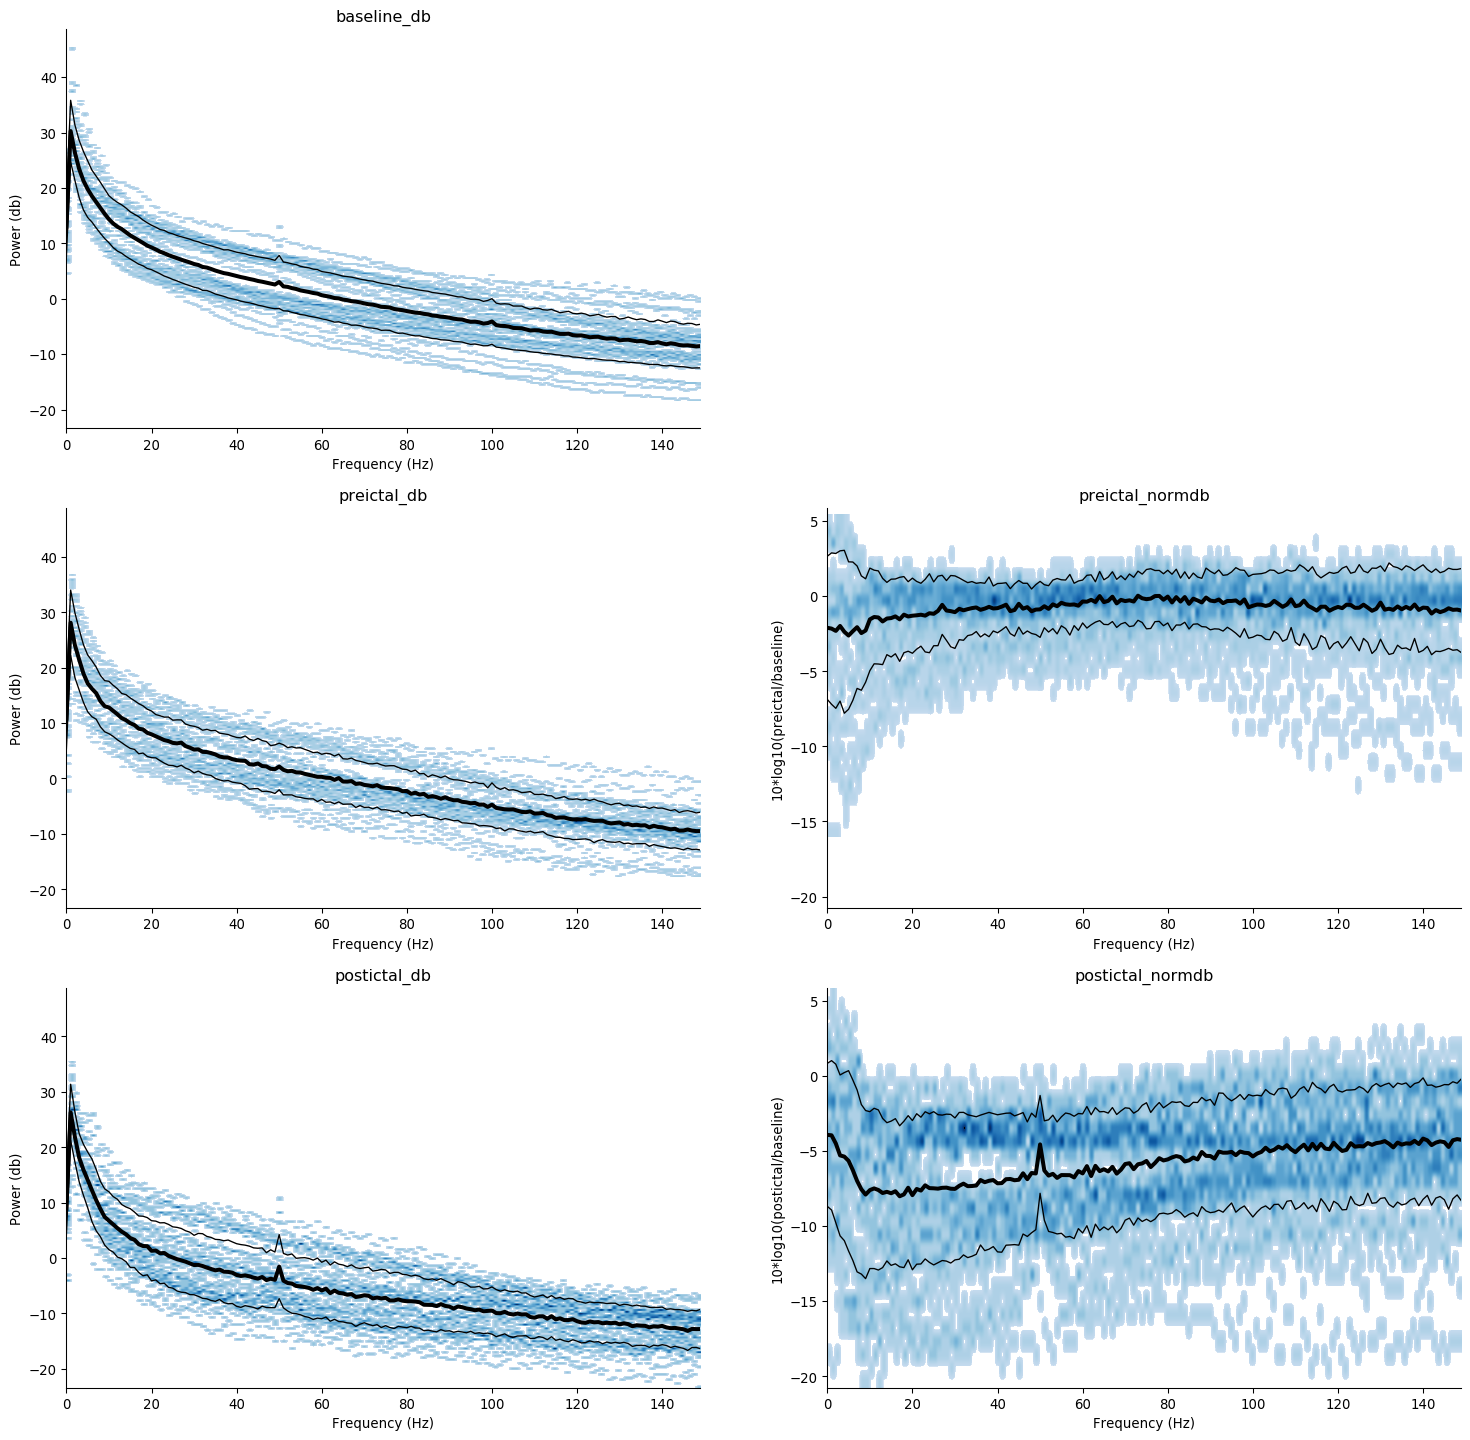

In [20]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'PSD_SD_withingroup_hist_comparisons.eps'
names = list(spg_strings_dic.keys())

my_dpi = 96
fig, ax = plt.subplots(len(names), 2, figsize=(1800/my_dpi, 1800/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    key_ix = names.index(period)
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        curr_ax = ax[key_ix][val_ix]
        
        data_to_plot = np.asarray(psds_dic[period][val_ix])
        mean_data, std_data = plot_period_hist_mean(curr_ax, data_to_plot)
        psds_means[period][val_ix].append(mean_data)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
        if val_ix == 0:
            curr_ax.set_ylabel('Power (db)')
        else:
            curr_ax.set_ylabel(f'10*log10({period}/baseline)')

ax[0][1].set_visible(False)
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

### Plot comparison between periods

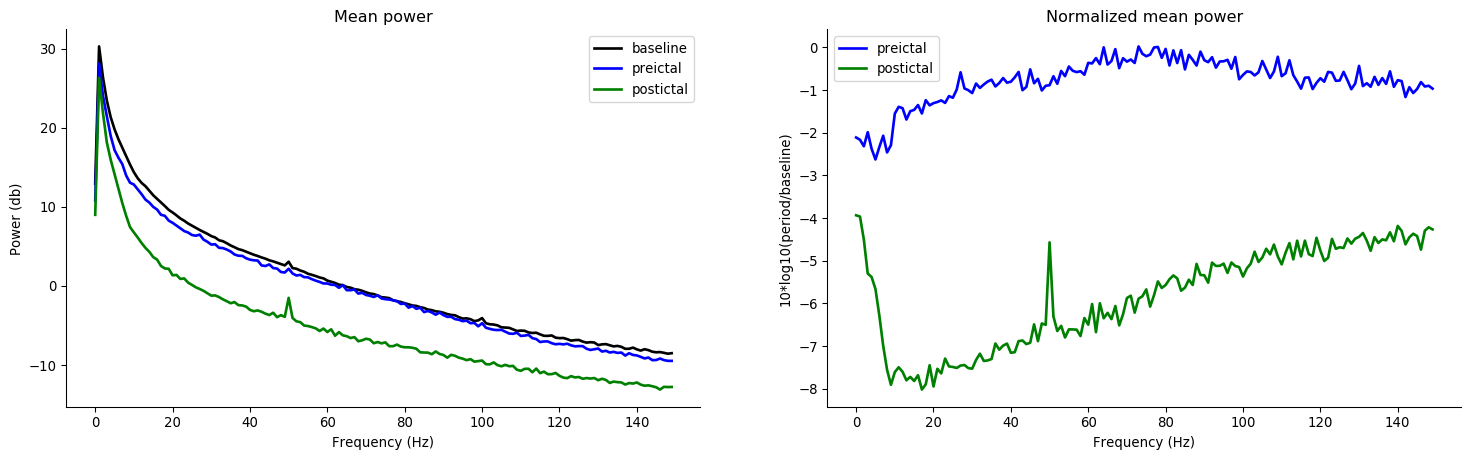

In [21]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'PSD_SD_withingroup_mean_comparisons.eps'


names = list(spg_strings_dic.keys())
my_dpi = 96
fig, ax = plt.subplots(1, 2, figsize=(1800/my_dpi, 500/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    if period == 'baseline':
        baseline_mean = psds_means[period][0][0]
        ax[0].plot(baseline_mean, color='k', lw=2, label=period)
        continue
    
    key_ix = names.index(period)-1

    if key_ix == 0:
        col = 'blue'
    else:
        col = 'green'
    
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        
        
        if val_ix == 0:
            curr_ax = ax[0]
        else:
            curr_ax = ax[1]
        
        #curr_ax = ax[key_ix][val_ix]
        curr_data = psds_means[period][val_ix][0]
        
        curr_ax.plot(curr_data, color=col, lw=2, label=period)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        #curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power (db)')
ax[1].set_ylabel(f'10*log10(period/baseline)')
ax[0].set_title('Mean power')
ax[0].legend()

ax[1].set_title('Normalized mean power')
ax[1].legend()
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

In [22]:
sd_res_dic = psds_means.copy()

### Get data for non-sd regions

In [23]:
non_sdinvaded_df = invaded_df[invaded_df['sdinvaded_region']==0]

In [24]:
spg_strings_dic = {'baseline' : ['spg_mean_db'],
                  'preictal' : ['spg_mean_db', 'spg_mean_normdb'],
                  'postictal' : ['spg_mean_first_db', 'spg_mean_first_normdb']}

psds_dic = {key:[[] for v in val] for key, val in spg_strings_dic.items()}
psds_means = {key:[[] for v in val] for key, val in spg_strings_dic.items()}

fmin = 0
fmax = 150


for index, row in non_sdinvaded_df.iterrows():
    patnr = row['pnr']
    sznr = row['sznr']
    chname = row['chname']
    fname = row['fname'].strip('.ncs')
    print(f"{patnr} {sznr} {chname} {fname}")
    
    sesspath = os.path.join(path_to_mat_data, f"{patnr}_{sznr}")
    
    
    matfile = loadmat(os.path.join(sesspath, f"{fname}_spg.mat"), squeeze_me=True)
    del matfile['__header__'], matfile['__version__'], matfile['__globals__']
    f_axis = matfile['f_axis']
    #t_axis = matfile['t_axis']
    #spg = matfile['spg']
    del matfile
    fmin_ix = np.searchsorted(f_axis, fmin)
    fmax_ix = np.searchsorted(f_axis, fmax)
    
    for period, keyval in spg_strings_dic.items():
        
        for key in keyval:
            matfile = loadmat(os.path.join(sesspath, f"{fname}_{period}.mat"), squeeze_me=True)
            val_ix = keyval.index(key)
            psd = matfile[key]
            psds_dic[period][val_ix].append(psd[fmin_ix:fmax_ix])
            del matfile

092 02 LA1 CSC1
092 02 LA2 CSC2
092 02 LA3 CSC3
092 02 LA4 CSC4
092 02 LA5 CSC5
092 02 LA6 CSC6
092 02 LA7 CSC7
092 02 LA8 CSC8
092 02 LAH1 CSC9
092 02 LAH2 CSC10
092 02 LAH3 CSC11
092 02 LAH4 CSC12
092 02 LAH5 CSC13
092 02 LAH6 CSC14
092 02 LAH7 CSC15
092 02 LAH8 CSC16
092 02 LEC1 CSC17
092 02 LEC2 CSC18
092 02 LEC3 CSC19
092 02 LEC4 CSC20
092 02 LEC5 CSC21
092 02 LEC6 CSC22
092 02 LEC7 CSC23
092 02 LEC8 CSC24
092 02 LMH1 CSC25
092 02 LMH2 CSC26
092 02 LMH3 CSC27
092 02 LMH4 CSC28
092 02 LMH5 CSC29
092 02 LMH6 CSC30
092 02 LMH7 CSC31
092 02 LMH8 CSC32
092 02 LPHC1 CSC33
092 02 LPHC2 CSC34
092 02 LPHC3 CSC35
092 02 LPHC4 CSC36
092 02 LPHC5 CSC37
092 02 LPHC6 CSC38
092 02 LPHC7 CSC39
092 02 LPHC8 CSC40
092 02 LPIC1 CSC41
092 02 LPIC2 CSC42
092 02 LPIC3 CSC43
092 02 LPIC4 CSC44
092 02 LPIC5 CSC45
092 02 LPIC6 CSC46
092 02 LPIC7 CSC47
092 02 LPIC8 CSC48
092 02 LTa1 CSC49
092 02 LTa2 CSC50
092 02 LTa3 CSC51
092 02 LTa4 CSC52
092 02 LTa5 CSC53
092 02 LTa6 CSC54
092 02 LTa7 CSC55
092 02 LTa8

092 03 LMH3 CSC27
092 03 LMH4 CSC28
092 03 LMH5 CSC29
092 03 LMH6 CSC30
092 03 LMH7 CSC31
092 03 LMH8 CSC32
092 03 LTa1 CSC49
092 03 LTa2 CSC50
092 03 LTa3 CSC51
092 03 LTa4 CSC52
092 03 LTa5 CSC53
092 03 LTa6 CSC54
092 03 LTa7 CSC55
092 03 LTa8 CSC56
092 03 LTb1 CSC57
092 03 LTb2 CSC58
092 03 LTb3 CSC59
092 03 LTb4 CSC60
092 03 LTb5 CSC61
092 03 LTb6 CSC62
092 03 LTb7 CSC63
092 03 LTb8 CSC64
089 01 LAH1 CSC9
089 01 LAH2 CSC10
089 01 LAH3 CSC11
089 01 LAH4 CSC12
089 01 LAH5 CSC13
089 01 LAH6 CSC14
089 01 LAH7 CSC15
089 01 LAH8 CSC16
089 01 LMH1 CSC25
089 01 LMH2 CSC26
089 01 LMH3 CSC27
089 01 LMH4 CSC28
089 01 LMH5 CSC29
089 01 LMH6 CSC30
089 01 LMH7 CSC31
089 01 LMH8 CSC32
089 01 LPHC1 CSC33
089 01 LPHC2 CSC34
089 01 LPHC3 CSC35
089 01 LPHC4 CSC36
089 01 LPHC5 CSC37
089 01 LPHC6 CSC38
089 01 LPHC7 CSC39
089 01 LPHC8 CSC40
089 01 LPIC1 CSC41
089 01 LPIC2 CSC42
089 01 LPIC3 CSC43
089 01 LPIC4 CSC44
089 01 LPIC5 CSC45
089 01 LPIC6 CSC46
089 01 LPIC7 CSC47
089 01 LPIC8 CSC48
081 02 RAH1 C

### plot periods of interest as PSDs

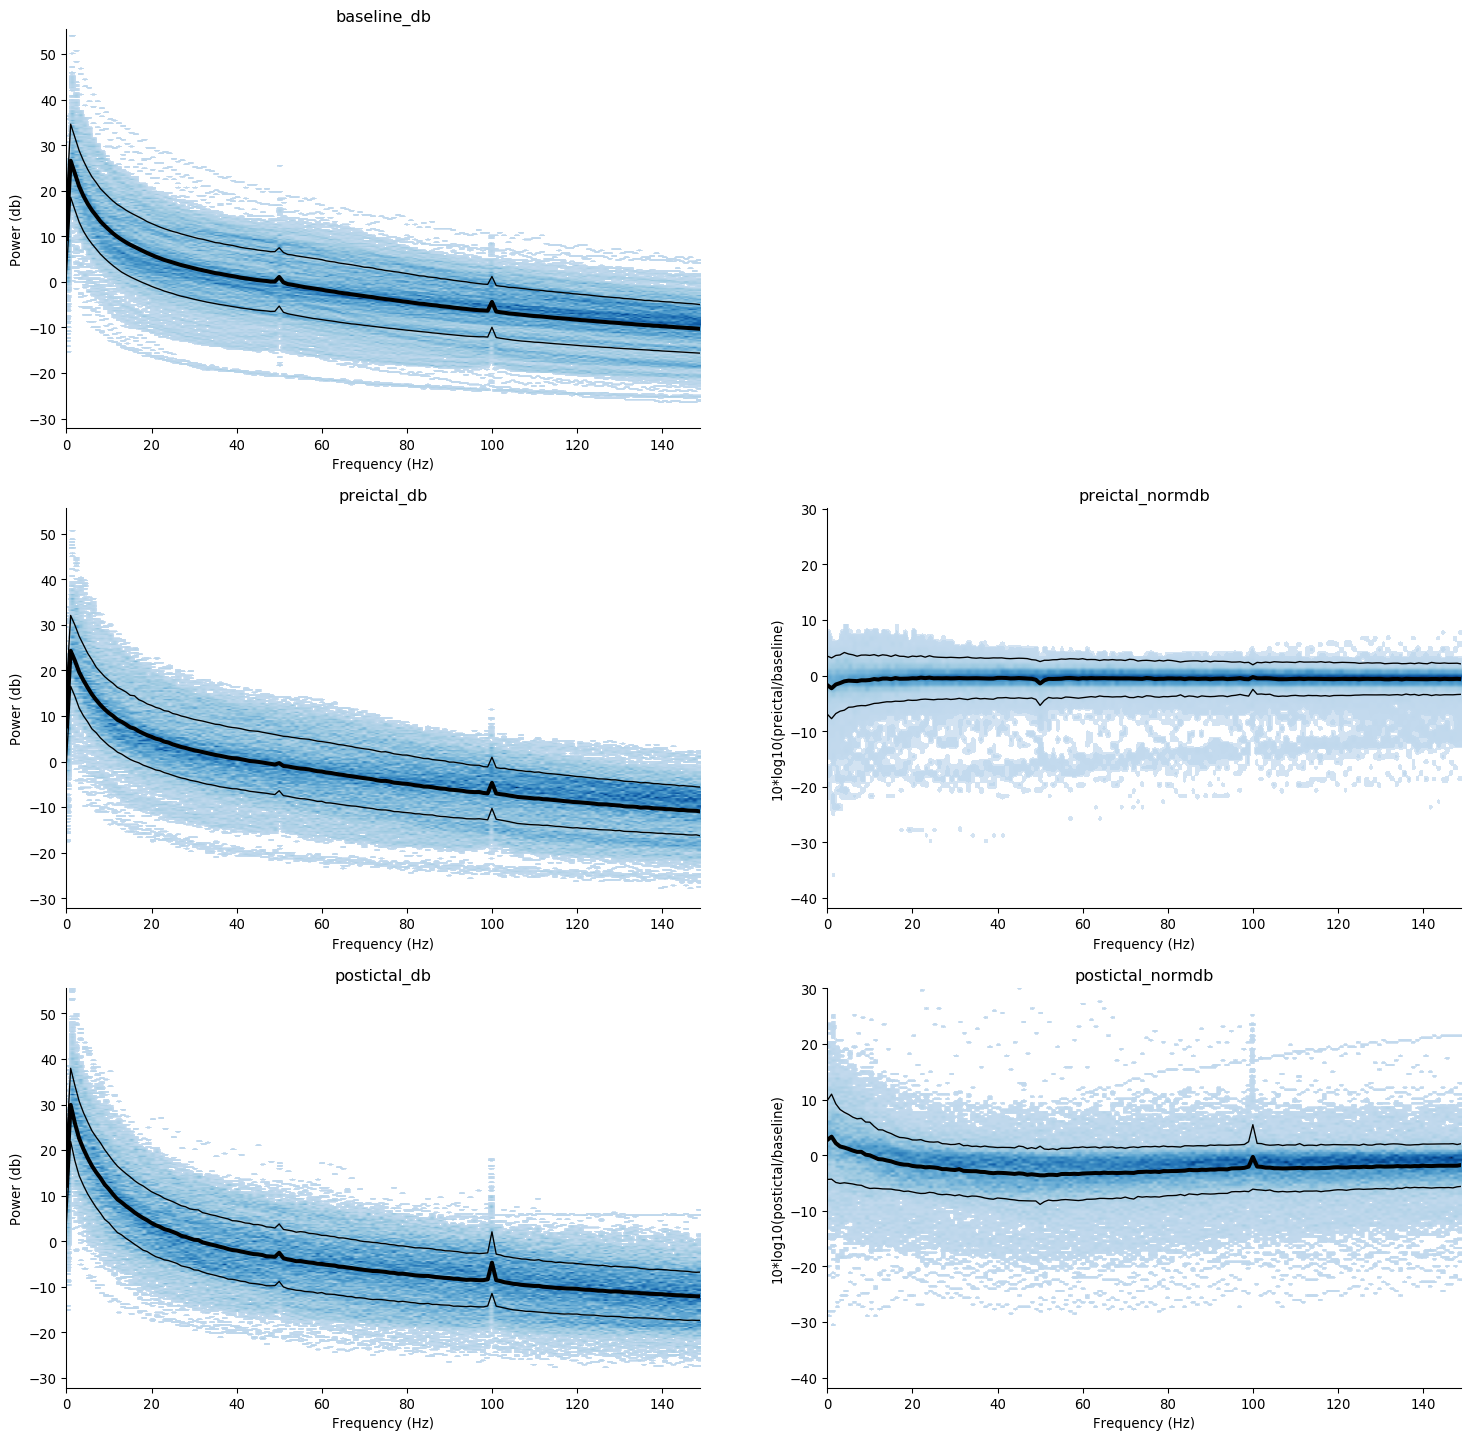

In [25]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'PSD_nonSD_withingroup_hist_comparisons.eps'
names = list(spg_strings_dic.keys())

my_dpi = 96
fig, ax = plt.subplots(len(names), 2, figsize=(1800/my_dpi, 1800/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    key_ix = names.index(period)
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        curr_ax = ax[key_ix][val_ix]
        
        data_to_plot = np.asarray(psds_dic[period][val_ix])
        mean_data, std_data = plot_period_hist_mean(curr_ax, data_to_plot)
        psds_means[period][val_ix].append(mean_data)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
        if val_ix == 0:
            curr_ax.set_ylabel('Power (db)')
        else:
            curr_ax.set_ylabel(f'10*log10({period}/baseline)')

ax[0][1].set_visible(False)
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

### Plot comparison between periods

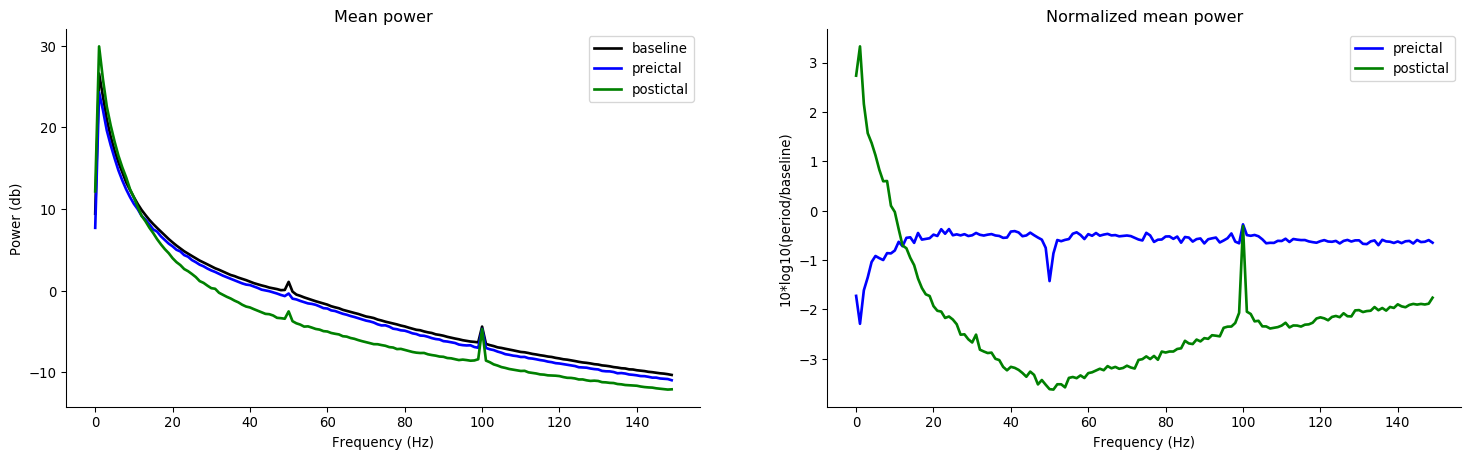

In [26]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'PSD_nonSD_withingroup_mean_comparisons.eps'


names = list(spg_strings_dic.keys())
my_dpi = 96
fig, ax = plt.subplots(1, 2, figsize=(1800/my_dpi, 500/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    if period == 'baseline':
        baseline_mean = psds_means[period][0][0]
        ax[0].plot(baseline_mean, color='k', lw=2, label=period)
        continue
    
    key_ix = names.index(period)-1

    if key_ix == 0:
        col = 'blue'
    else:
        col = 'green'
    
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        
        
        if val_ix == 0:
            curr_ax = ax[0]
        else:
            curr_ax = ax[1]
        
        #curr_ax = ax[key_ix][val_ix]
        curr_data = psds_means[period][val_ix][0]
        
        curr_ax.plot(curr_data, color=col, lw=2, label=period)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        #curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power (db)')
ax[1].set_ylabel(f'10*log10(period/baseline)')
ax[0].set_title('Mean power')
ax[0].legend()

ax[1].set_title('Normalized mean power')
ax[1].legend()
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

In [27]:
nonsd_res_dic = psds_means.copy()

### save results

In [37]:
baseline_dic = {'SD_mean_db' : sd_res_dic['baseline'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['baseline'][0][0].tolist()}

preictal_dic = {'SD_mean_db' : sd_res_dic['preictal'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['preictal'][0][0].tolist(),
               'SD_mean_normdb' : sd_res_dic['preictal'][1][0].tolist(),
               'nonSD_mean_normdb' : nonsd_res_dic['preictal'][1][0].tolist()}

postictal_dic = {'SD_mean_db' : sd_res_dic['postictal'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['postictal'][0][0].tolist(),
               'SD_mean_normdb' : sd_res_dic['postictal'][1][0].tolist(),
               'nonSD_mean_normdb' : nonsd_res_dic['postictal'][1][0].tolist()}

In [56]:
savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'

savemat(os.path.join(savepath, 'baseline_psds.mat'), baseline_dic)
savemat(os.path.join(savepath, 'preictal_psds.mat'), preictal_dic)
savemat(os.path.join(savepath, 'postictal_psds.mat'), postictal_dic)

In [40]:
pospre_diff_normdb_nonsd = np.subtract(nonsd_res_dic['postictal'][1][0], nonsd_res_dic['preictal'][1][0])
pospre_diff_normdb_sd = np.subtract(sd_res_dic['postictal'][1][0], sd_res_dic['preictal'][1][0])



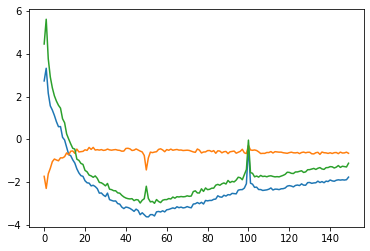

In [54]:
plt.plot(nonsd_res_dic['postictal'][1][0])
plt.plot(nonsd_res_dic['preictal'][1][0])
plt.plot(nonsd_res_dic['postictal'][1][0]-nonsd_res_dic['preictal'][1][0])
plt.show()

# Plot comparison between groups

In [256]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
#figname = 'PSD_nonSD_withingroup_mean_comparisons.eps'

baseline_sd = sd_res_dic['baseline'][0][0]
baseline_nonsd = nonsd_res_dic['baseline'][0][0]

preictal_sd_db = sd_res_dic['preictal'][0][0]
preictal_nonsd_db = nonsd_res_dic['preictal'][0][0]
preictal_sd_normdb = sd_res_dic['preictal'][1][0]
preictal_nonsd_normdb = nonsd_res_dic['preictal'][1][0]


postictal_sd_db = sd_res_dic['postictal'][0][0]
postictal_nonsd_db = nonsd_res_dic['postictal'][0][0]
postictal_sd_normdb = sd_res_dic['postictal'][1][0]
postictal_nonsd_normdb = nonsd_res_dic['postictal'][1][0]

In [ ]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Baseline' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(baseline_sd, color='k', lw=2, label='SD')
ax.plot(baseline_nonsd, color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Baseline')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


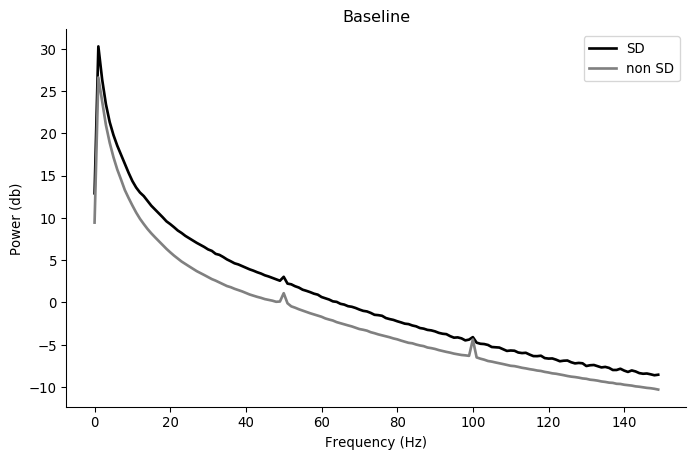

In [267]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Preictal' + '_comparison.eps'
my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(preictal_sd_db, color='k', lw=2, label='SD')
ax.plot(preictal_nonsd_db, color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Preictal')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


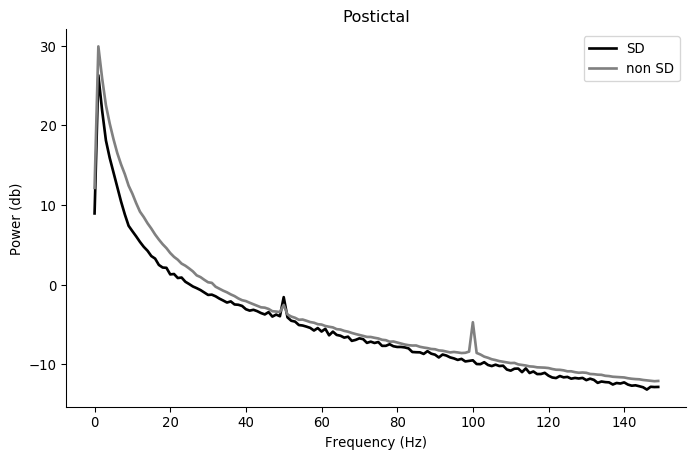

In [269]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Postictal' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(postictal_sd_db, color='k', lw=2, label='SD')
ax.plot(postictal_nonsd_db, color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Postictal')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


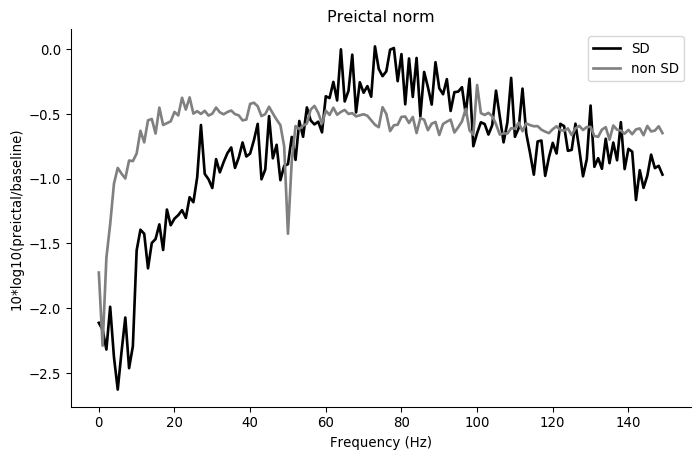

In [270]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Preictal_norm' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(preictal_sd_normdb, color='k', lw=2, label='SD')
ax.plot(preictal_nonsd_normdb, color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
#ax.set_ylabel('Power (db)')
ax.set_ylabel(f'10*log10(preictal/baseline)')
ax.set_title('Preictal norm')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


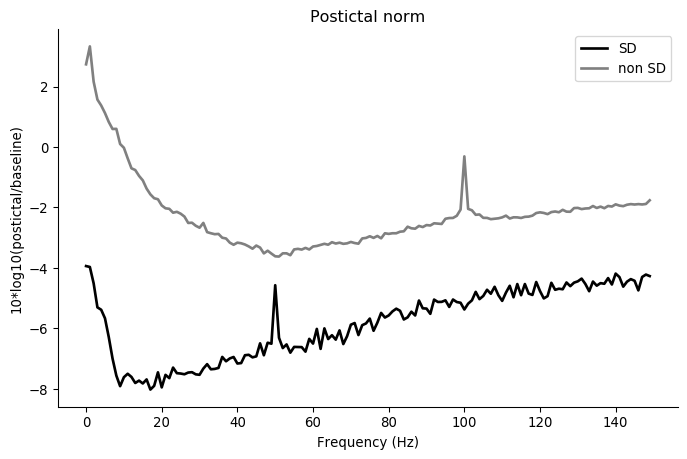

In [271]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Postictal_norm' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(postictal_sd_normdb, color='k', lw=2, label='SD')
ax.plot(postictal_nonsd_normdb, color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
#ax.set_ylabel('Power (db)')
ax.set_ylabel(f'10*log10(postictal/baseline)')
ax.set_title('Postictal norm')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


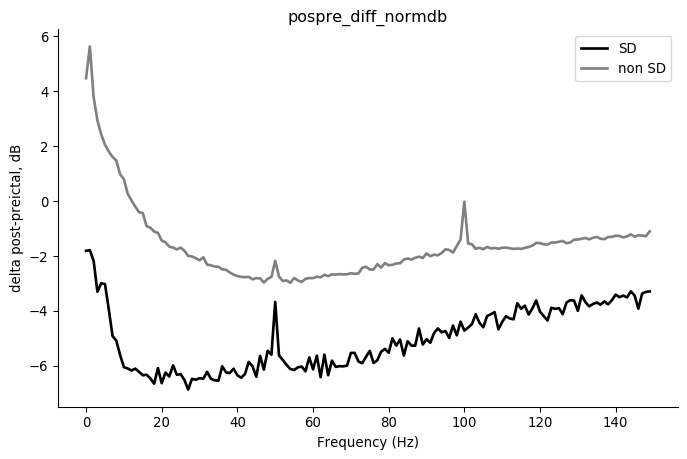

In [55]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'pospre_diff_normdb' + '.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(sd_res_dic['postictal'][1][0]-sd_res_dic['preictal'][1][0], color='k', lw=2, label='SD')
ax.plot(nonsd_res_dic['postictal'][1][0]-nonsd_res_dic['preictal'][1][0], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('delta post-preictal, dB')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('pospre_diff_normdb')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

## Do the same for macros

### convert to macro names

In [7]:
data_df['chname'] = from_micro_to_macro_names_new(data_df['chname'].tolist())
data_df['region'] = [x[:-1] for x in data_df['chname'].tolist()]
data_df['sf'] = 2000
data_df['datapath'] = [x.split('DS_data')[0]+'macro/DS_data/reref' for x in data_df['datapath'].tolist()]


macro_df = data_df[data_df['chname'].str.contains('1')]
macro_df = macro_df.reset_index(drop=True)

#invaded_df = macro_df.loc[szinv]

macro_df['sdinvaded_region'] = pd.to_numeric(macro_df['sdinvaded_region'], errors='coerce').fillna(0)
szinvaded_index = macro_df.index[macro_df['seizureinvaded']==1]
invaded_df = macro_df.loc[szinvaded_index]
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

### Get data for SD regions

In [8]:
sdinvaded_df = data_df.loc[sdinv]
sdinvaded_df['sdinvaded_region'] = pd.to_numeric(sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)

In [272]:
names = list(spg_strings_dic.keys())
my_dpi = 96
#fig, ax = plt.subplots(1, 2, figsize=(1800/my_dpi, 500/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    if period == 'baseline':
        baseline_mean = psds_means[period][0][0]
        ax[0].plot(baseline_mean, color='k', lw=2, label=period)
        continue
    
    key_ix = names.index(period)-1

    if key_ix == 0:
        col = 'blue'
    else:
        col = 'green'
    
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        
        
        if val_ix == 0:
            curr_ax = ax[0]
        else:
            curr_ax = ax[1]
        
        #curr_ax = ax[key_ix][val_ix]
        curr_data = psds_means[period][val_ix][0]
        
        curr_ax.plot(curr_data, color=col, lw=2, label=period)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        #curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power (db)')
ax[1].set_ylabel(f'10*log10(period/baseline)')
ax[0].set_title('Mean power')
ax[0].legend()

ax[1].set_title('Normalized mean power')
ax[1].legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)

#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

___
# Filter data by SD-invaded seizures only

In [60]:
dpath = '/media/Seizures/Wenzel/dataframes_patpool/'
data_df, szinv, sdinv, nonsdinv = get_sddata_from_dataframes(dpath, exclude_str='100')

data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_df['sdinvaded_region'] = pd.to_numeric(data_df['sdinvaded_region'], errors='coerce').fillna(0)


invaded_df = data_df.loc[szinv]
invaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

#Filter data by SD-invaded seizures only

mask = data_df.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
data_df = data_df[mask]

mask = invaded_df.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
invaded_df = invaded_df[mask]


sdinvaded_df = invaded_df[invaded_df['sdinvaded_region']==1]
sdinvaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sdinvaded_df['sdinvaded_region'] = pd.to_numeric(sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)

non_sdinvaded_df = invaded_df[invaded_df['sdinvaded_region']==0]
non_sdinvaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
non_sdinvaded_df['sdinvaded_region'] = pd.to_numeric(non_sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)


/tmp/ipykernel_43661/464663368.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdinvaded_df.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_43661/464663368.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdinvaded_df['sdinvaded_region'] = pd.to_numeric(sdinvaded_df['sdinvaded_region'], errors='coerce').fillna(0)
/tmp/ipykernel_43661/464663368.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [61]:
spg_strings_dic = {'baseline' : ['spg_mean_db'],
                  'preictal' : ['spg_mean_db', 'spg_mean_normdb'],
                  'postictal' : ['spg_mean_first_db', 'spg_mean_first_normdb']}

psds_dic = {key:[[] for v in val] for key, val in spg_strings_dic.items()}
psds_means = {key:[[] for v in val] for key, val in spg_strings_dic.items()}

fmin = 0
fmax = 150


for index, row in sdinvaded_df.iterrows():
    patnr = row['pnr']
    sznr = row['sznr']
    chname = row['chname']
    fname = row['fname'].strip('.ncs')
    print(f"{patnr} {sznr} {chname} {fname}")
    
    sesspath = os.path.join(path_to_mat_data, f"{patnr}_{sznr}")
    
    
    matfile = loadmat(os.path.join(sesspath, f"{fname}_spg.mat"), squeeze_me=True)
    del matfile['__header__'], matfile['__version__'], matfile['__globals__']
    f_axis = matfile['f_axis']
    #t_axis = matfile['t_axis']
    #spg = matfile['spg']
    del matfile
    fmin_ix = np.searchsorted(f_axis, fmin)
    fmax_ix = np.searchsorted(f_axis, fmax)
    
    for period, keyval in spg_strings_dic.items():
        
        for key in keyval:
            matfile = loadmat(os.path.join(sesspath, f"{fname}_{period}.mat"), squeeze_me=True)
            val_ix = keyval.index(key)
            psd = matfile[key]
            psds_dic[period][val_ix].append(psd[fmin_ix:fmax_ix])
            del matfile

081 03 RAH1 CSC1
081 03 RAH2 CSC2
081 03 RAH3 CSC3
081 03 RAH4 CSC4
081 03 RAH5 CSC5
081 03 RAH6 CSC6
081 03 RAH7 CSC7
081 03 RAH8 CSC8
074 03 RA1 CSC41
074 03 RA2 CSC42
074 03 RA3 CSC43
074 03 RA4 CSC44
074 03 RA5 CSC45
074 03 RA6 CSC46
074 03 RA7 CSC47
074 03 RA8 CSC48
074 03 RAH1 CSC49
074 03 RAH2 CSC50
074 03 RAH3 CSC51
074 03 RAH4 CSC52
074 03 RAH5 CSC53
074 03 RAH6 CSC54
074 03 RAH7 CSC55
074 03 RAH8 CSC56
092 03 LAH1 CSC9
092 03 LAH2 CSC10
092 03 LAH3 CSC11
092 03 LAH4 CSC12
092 03 LAH5 CSC13
092 03 LAH6 CSC14
092 03 LAH7 CSC15
092 03 LAH8 CSC16
089 01 LA1 CSC1
089 01 LA2 CSC2
089 01 LA3 CSC3
089 01 LA4 CSC4
089 01 LA5 CSC5
089 01 LA6 CSC6
089 01 LA7 CSC7
089 01 LA8 CSC8


### plot periods of interest as PSD

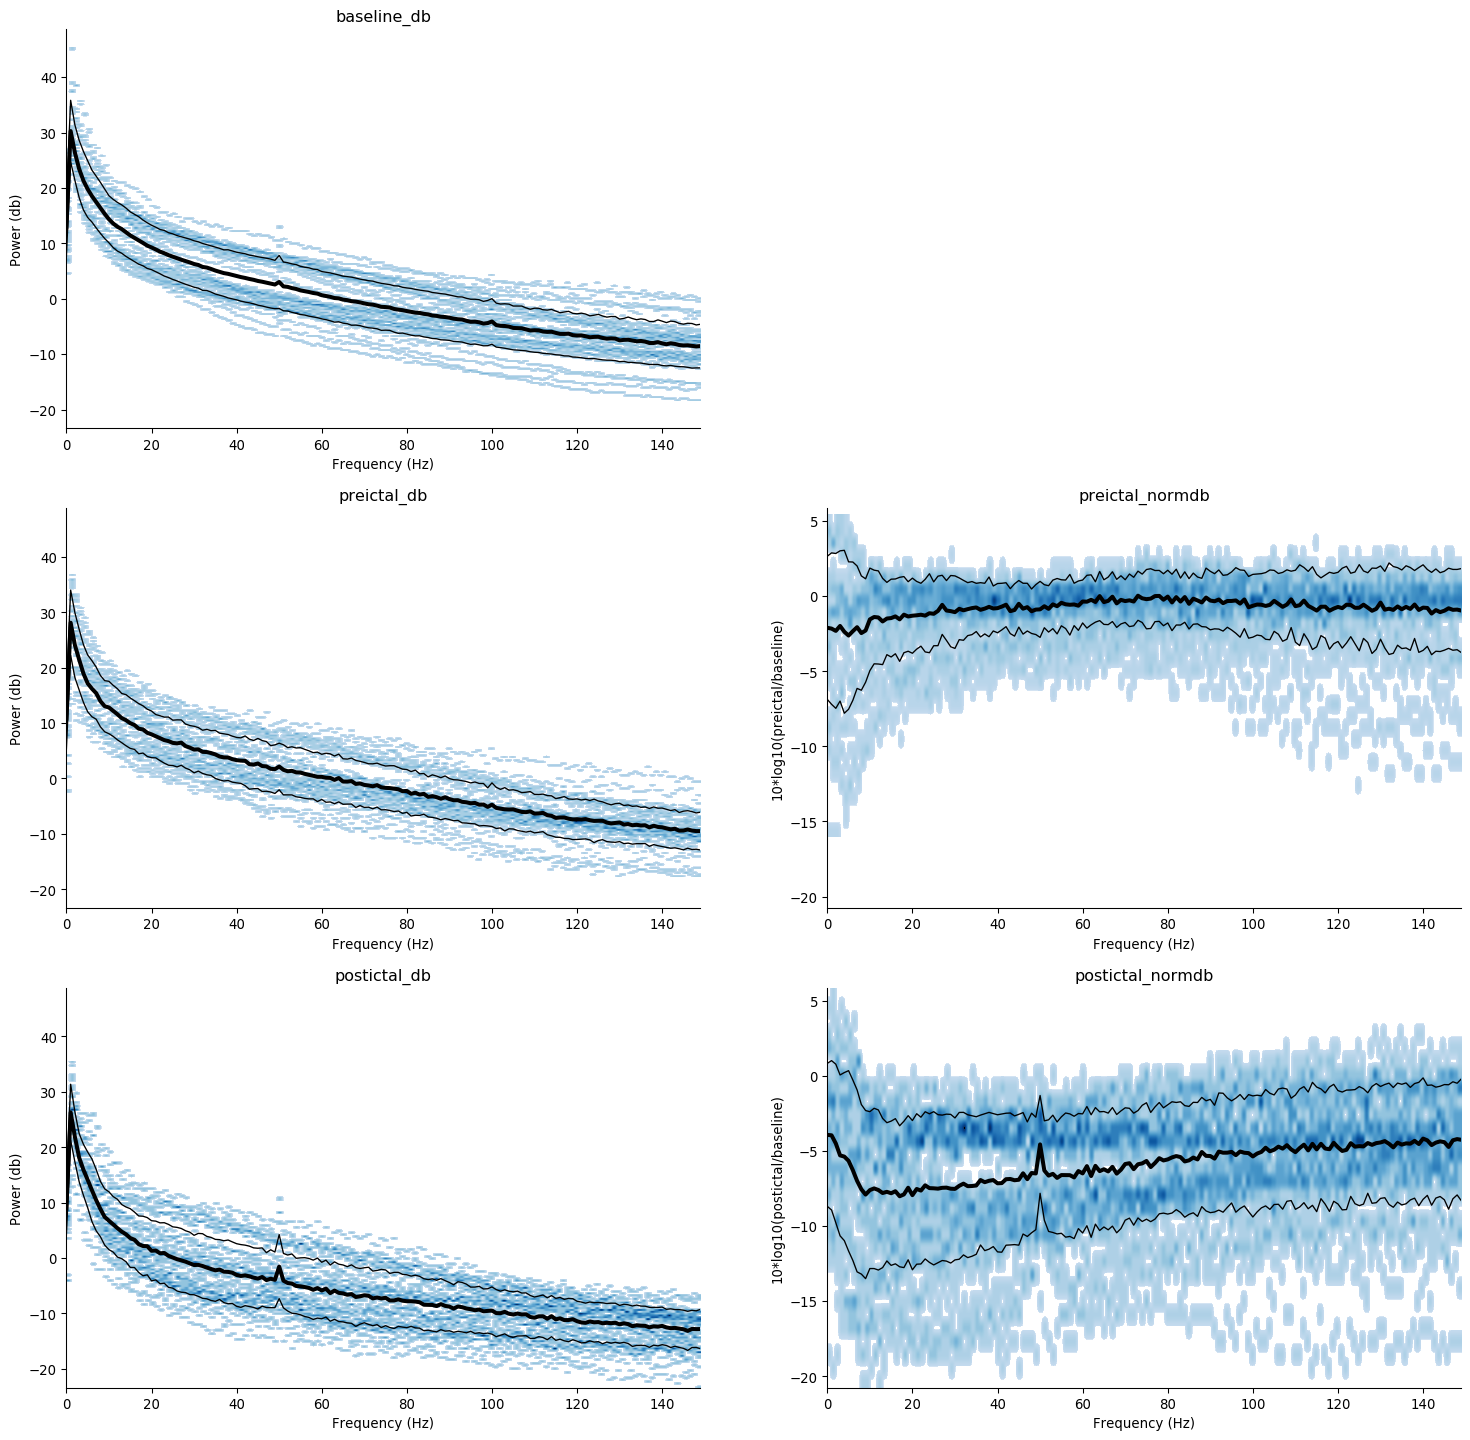

In [63]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only'
figname = 'PSD_SD_withingroup_hist_comparisons.eps'
names = list(spg_strings_dic.keys())

my_dpi = 96
fig, ax = plt.subplots(len(names), 2, figsize=(1800/my_dpi, 1800/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    key_ix = names.index(period)
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        curr_ax = ax[key_ix][val_ix]
        
        data_to_plot = np.asarray(psds_dic[period][val_ix])
        mean_data, std_data = plot_period_hist_mean(curr_ax, data_to_plot)
        psds_means[period][val_ix].append(mean_data)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
        if val_ix == 0:
            curr_ax.set_ylabel('Power (db)')
        else:
            curr_ax.set_ylabel(f'10*log10({period}/baseline)')

ax[0][1].set_visible(False)
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

### plot comparison between means

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


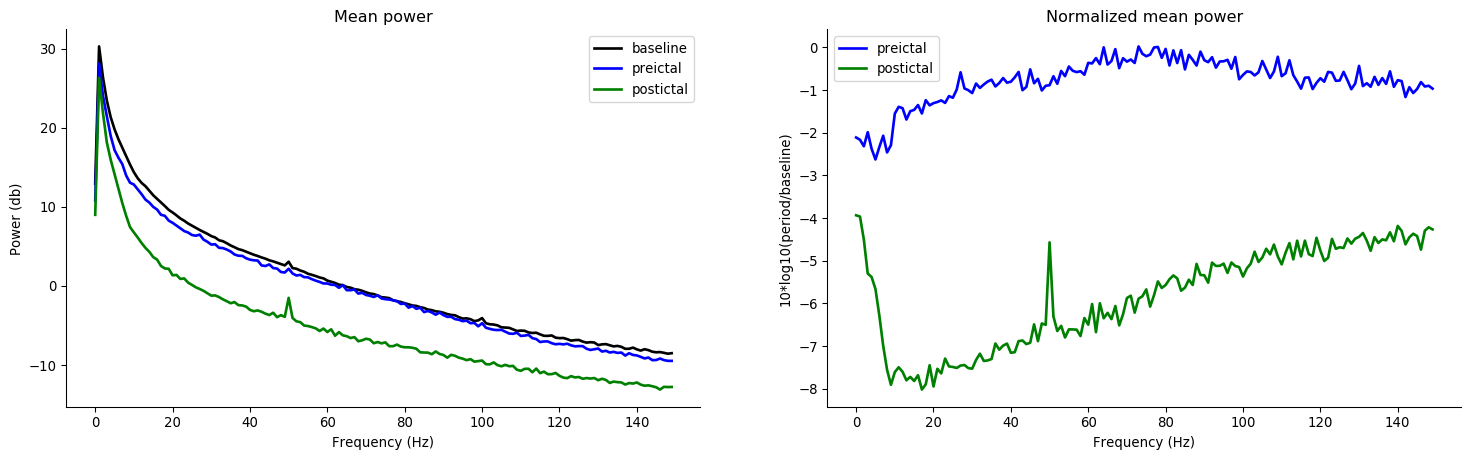

In [64]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only'
figname = 'PSD_SD_withingroup_mean_comparisons.eps'


names = list(spg_strings_dic.keys())
my_dpi = 96
fig, ax = plt.subplots(1, 2, figsize=(1800/my_dpi, 500/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    if period == 'baseline':
        baseline_mean = psds_means[period][0][0]
        ax[0].plot(baseline_mean, color='k', lw=2, label=period)
        continue
    
    key_ix = names.index(period)-1

    if key_ix == 0:
        col = 'blue'
    else:
        col = 'green'
    
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        
        
        if val_ix == 0:
            curr_ax = ax[0]
        else:
            curr_ax = ax[1]
        
        #curr_ax = ax[key_ix][val_ix]
        curr_data = psds_means[period][val_ix][0]
        
        curr_ax.plot(curr_data, color=col, lw=2, label=period)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        #curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power (db)')
ax[1].set_ylabel(f'10*log10(period/baseline)')
ax[0].set_title('Mean power')
ax[0].legend()

ax[1].set_title('Normalized mean power')
ax[1].legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

In [65]:
sd_res_dic = psds_means.copy()

### Do the same for non-sd-invaded regions

In [66]:
spg_strings_dic = {'baseline' : ['spg_mean_db'],
                  'preictal' : ['spg_mean_db', 'spg_mean_normdb'],
                  'postictal' : ['spg_mean_first_db', 'spg_mean_first_normdb']}

psds_dic = {key:[[] for v in val] for key, val in spg_strings_dic.items()}
psds_means = {key:[[] for v in val] for key, val in spg_strings_dic.items()}

fmin = 0
fmax = 150


for index, row in non_sdinvaded_df.iterrows():
    patnr = row['pnr']
    sznr = row['sznr']
    chname = row['chname']
    fname = row['fname'].strip('.ncs')
    print(f"{patnr} {sznr} {chname} {fname}")
    
    sesspath = os.path.join(path_to_mat_data, f"{patnr}_{sznr}")
    
    
    matfile = loadmat(os.path.join(sesspath, f"{fname}_spg.mat"), squeeze_me=True)
    del matfile['__header__'], matfile['__version__'], matfile['__globals__']
    f_axis = matfile['f_axis']
    #t_axis = matfile['t_axis']
    #spg = matfile['spg']
    del matfile
    fmin_ix = np.searchsorted(f_axis, fmin)
    fmax_ix = np.searchsorted(f_axis, fmax)
    
    for period, keyval in spg_strings_dic.items():
        
        for key in keyval:
            matfile = loadmat(os.path.join(sesspath, f"{fname}_{period}.mat"), squeeze_me=True)
            val_ix = keyval.index(key)
            psd = matfile[key]
            psds_dic[period][val_ix].append(psd[fmin_ix:fmax_ix])
            del matfile

081 03 RTa1 CSC9
081 03 RTa2 CSC10
081 03 RTa3 CSC11
081 03 RTa4 CSC12
081 03 RTa5 CSC13
081 03 RTa6 CSC14
081 03 RTa7 CSC15
081 03 RTa8 CSC16
081 03 RTc1 CSC25
081 03 RTc2 CSC26
081 03 RTc3 CSC27
081 03 RTc4 CSC28
081 03 RTc5 CSC29
081 03 RTc6 CSC30
081 03 RTc7 CSC31
081 03 RTc8 CSC32
074 03 LA1 CSC1
074 03 LA2 CSC2
074 03 LA3 CSC3
074 03 LA4 CSC4
074 03 LA5 CSC5
074 03 LA6 CSC6
074 03 LA7 CSC7
074 03 LA8 CSC8
074 03 LAH1 CSC9
074 03 LAH2 CSC10
074 03 LAH3 CSC11
074 03 LAH4 CSC12
074 03 LAH5 CSC13
074 03 LAH6 CSC14
074 03 LAH7 CSC15
074 03 LAH8 CSC16
074 03 LEC1 CSC17
074 03 LEC2 CSC18
074 03 LEC3 CSC19
074 03 LEC4 CSC20
074 03 LEC5 CSC21
074 03 LEC6 CSC22
074 03 LEC7 CSC23
074 03 LEC8 CSC24
074 03 LMH1 CSC25
074 03 LMH2 CSC26
074 03 LMH3 CSC27
074 03 LMH4 CSC28
074 03 LMH5 CSC29
074 03 LMH6 CSC30
074 03 LMH7 CSC31
074 03 LMH8 CSC32
074 03 LPHC1 CSC33
074 03 LPHC2 CSC34
074 03 LPHC3 CSC35
074 03 LPHC4 CSC36
074 03 LPHC5 CSC37
074 03 LPHC6 CSC38
074 03 LPHC7 CSC39
074 03 LPHC8 CSC40
07

### plot periods of interest as PSDs

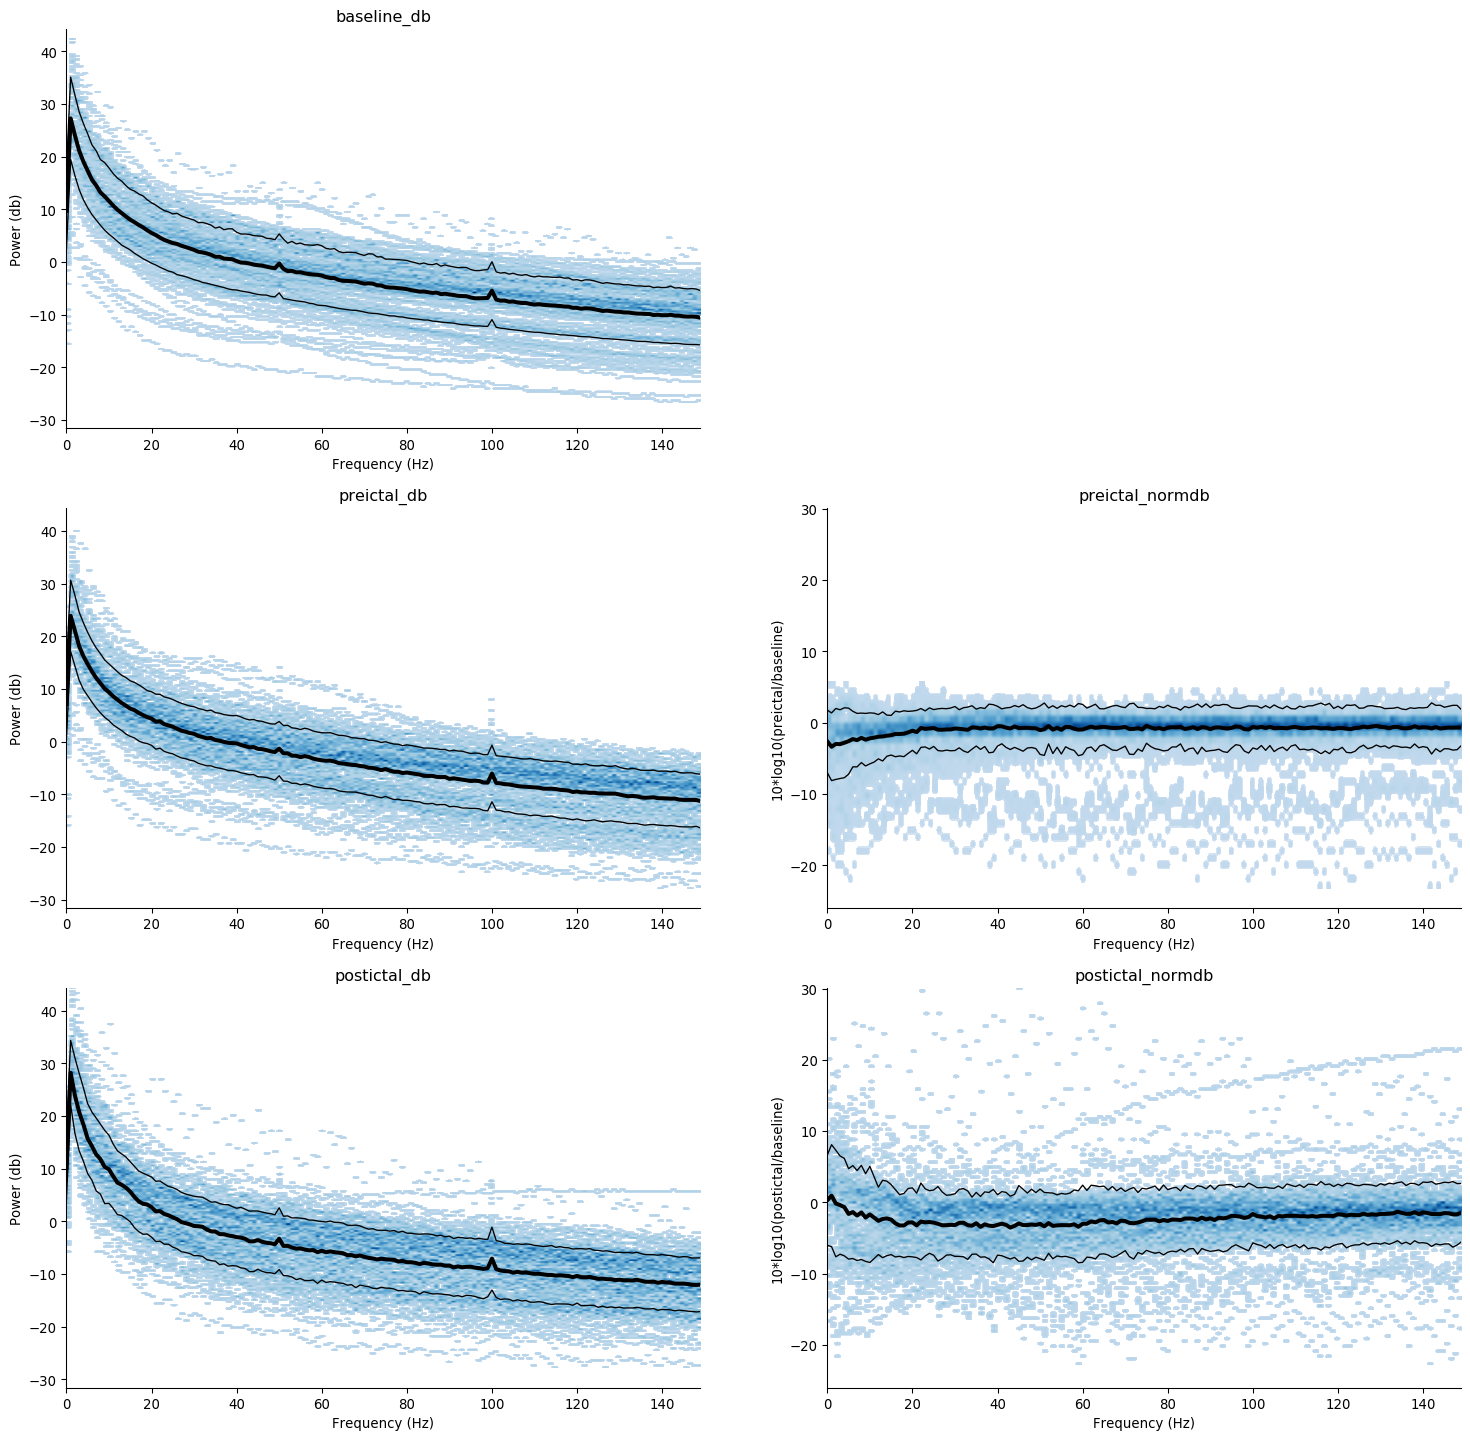

In [67]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only/'
figname = 'PSD_nonSD_withingroup_hist_comparisons.eps'
names = list(spg_strings_dic.keys())

my_dpi = 96
fig, ax = plt.subplots(len(names), 2, figsize=(1800/my_dpi, 1800/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    key_ix = names.index(period)
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        curr_ax = ax[key_ix][val_ix]
        
        data_to_plot = np.asarray(psds_dic[period][val_ix])
        mean_data, std_data = plot_period_hist_mean(curr_ax, data_to_plot)
        psds_means[period][val_ix].append(mean_data)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
        if val_ix == 0:
            curr_ax.set_ylabel('Power (db)')
        else:
            curr_ax.set_ylabel(f'10*log10({period}/baseline)')

ax[0][1].set_visible(False)
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


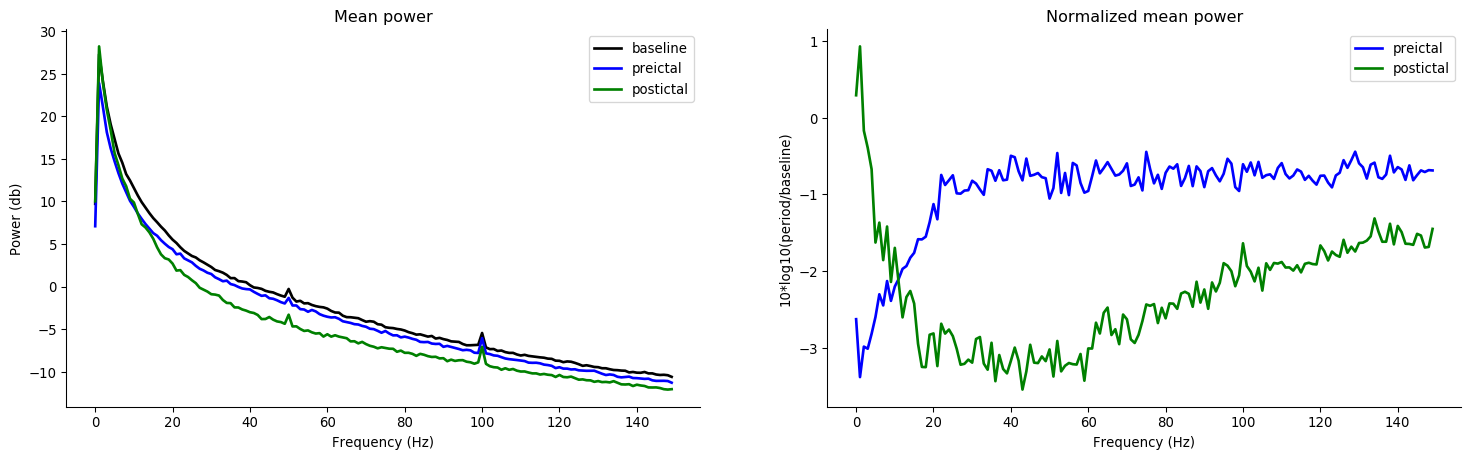

In [68]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only/'
figname = 'PSD_nonSD_withingroup_mean_comparisons.eps'


names = list(spg_strings_dic.keys())
my_dpi = 96
fig, ax = plt.subplots(1, 2, figsize=(1800/my_dpi, 500/my_dpi), dpi=my_dpi, sharey='col')
for period, keyval in spg_strings_dic.items():
    
    if period == 'baseline':
        baseline_mean = psds_means[period][0][0]
        ax[0].plot(baseline_mean, color='k', lw=2, label=period)
        continue
    
    key_ix = names.index(period)-1

    if key_ix == 0:
        col = 'blue'
    else:
        col = 'green'
    
    
    #print(len(keyval))
    for key in keyval:
        val_ix = keyval.index(key)
        
        
        if val_ix == 0:
            curr_ax = ax[0]
        else:
            curr_ax = ax[1]
        
        #curr_ax = ax[key_ix][val_ix]
        curr_data = psds_means[period][val_ix][0]
        
        curr_ax.plot(curr_data, color=col, lw=2, label=period)
        
        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        #curr_ax.set_title(period + '_' + key.split('_')[-1])
        curr_ax.set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power (db)')
ax[1].set_ylabel(f'10*log10(period/baseline)')
ax[0].set_title('Mean power')
ax[0].legend()

ax[1].set_title('Normalized mean power')
ax[1].legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

In [74]:
nonsd_res_dic = psds_means.copy()

### save results

In [75]:
baseline_dic = {'SD_mean_db' : sd_res_dic['baseline'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['baseline'][0][0].tolist()}

preictal_dic = {'SD_mean_db' : sd_res_dic['preictal'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['preictal'][0][0].tolist(),
               'SD_mean_normdb' : sd_res_dic['preictal'][1][0].tolist(),
               'nonSD_mean_normdb' : nonsd_res_dic['preictal'][1][0].tolist()}

postictal_dic = {'SD_mean_db' : sd_res_dic['postictal'][0][0].tolist(),
               'nonSD_mean_db' : nonsd_res_dic['postictal'][0][0].tolist(),
               'SD_mean_normdb' : sd_res_dic['postictal'][1][0].tolist(),
               'nonSD_mean_normdb' : nonsd_res_dic['postictal'][1][0].tolist()}


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only/'

savemat(os.path.join(savepath, 'baseline_psds.mat'), baseline_dic)
savemat(os.path.join(savepath, 'preictal_psds.mat'), preictal_dic)
savemat(os.path.join(savepath, 'postictal_psds.mat'), postictal_dic)

## Load results

In [102]:
baseline_dic = loadmat(os.path.join(savepath, 'baseline_psds.mat'), squeeze_me=True)
preictal_dic = loadmat(os.path.join(savepath, 'preictal_psds.mat'), squeeze_me=True)
postictal_dic = loadmat(os.path.join(savepath, 'postictal_psds.mat'), squeeze_me=True)

## Plot comparisons between groups

In [76]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
#figname = 'PSD_nonSD_withingroup_mean_comparisons.eps'

baseline_sd = sd_res_dic['baseline'][0][0]
baseline_nonsd = nonsd_res_dic['baseline'][0][0]

preictal_sd_db = sd_res_dic['preictal'][0][0]
preictal_nonsd_db = nonsd_res_dic['preictal'][0][0]
preictal_sd_normdb = sd_res_dic['preictal'][1][0]
preictal_nonsd_normdb = nonsd_res_dic['preictal'][1][0]


postictal_sd_db = sd_res_dic['postictal'][0][0]
postictal_nonsd_db = nonsd_res_dic['postictal'][0][0]
postictal_sd_normdb = sd_res_dic['postictal'][1][0]
postictal_nonsd_normdb = nonsd_res_dic['postictal'][1][0]

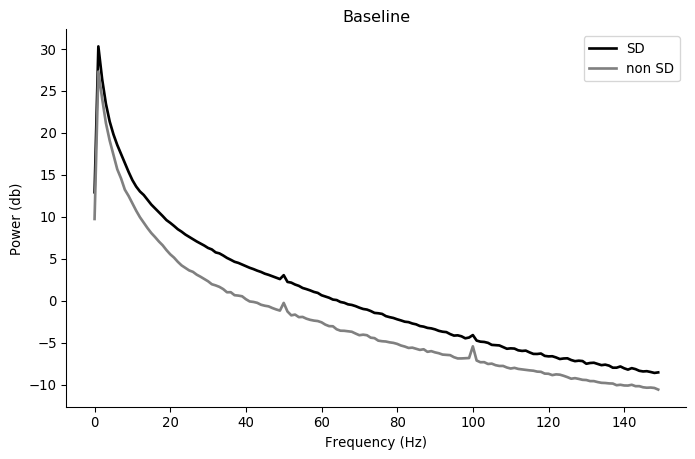

In [86]:
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/sdseizures_only/'
figname = 'Baseline' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(baseline_dic['SD_mean_db'], color='k', lw=2, label='SD')
ax.plot(baseline_dic['nonSD_mean_db'], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Baseline')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

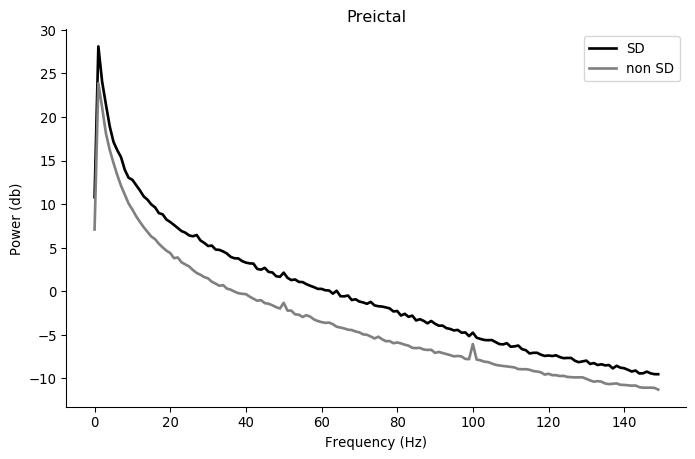

In [87]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Preictal' + '_comparison.eps'
my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(preictal_dic['SD_mean_db'], color='k', lw=2, label='SD')
ax.plot(preictal_dic['nonSD_mean_db'], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Preictal')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


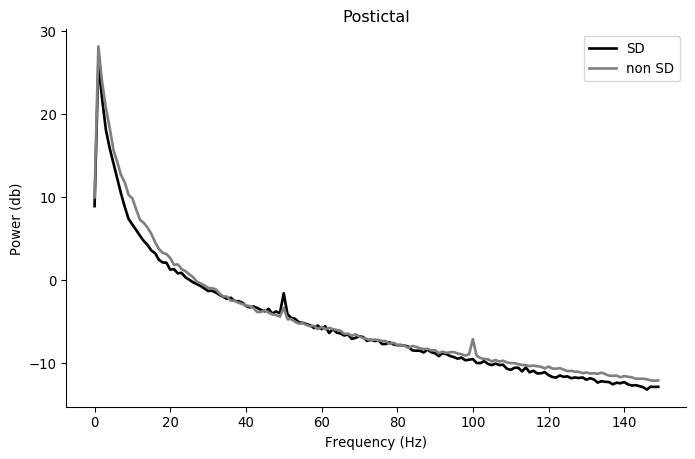

In [80]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Postictal' + '_comparison.eps'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(postictal_dic['SD_mean_db'], color='k', lw=2, label='SD')
ax.plot(postictal_dic['nonSD_mean_db'], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(period/baseline)')
ax.set_title('Postictal')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)

plt.show()

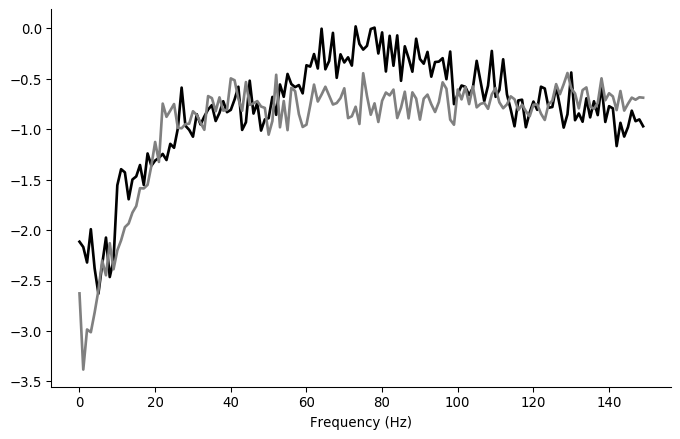

In [103]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Preictal_norm' + '_comparison.png'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(preictal_dic['SD_mean_normdb'], color='k', lw=2, label='SD')
ax.plot(preictal_dic['nonSD_mean_normdb'], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
#ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(preictal/baseline)')
#ax.set_title('Preictal norm')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend()
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.savefig(os.path.join(saveplot_path, figname), format='png', dpi=600, transparent=True)

plt.show()

In [99]:
preictal_dic

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Aug 27 12:55:14 2024',
 '__version__': '1.0',
 '__globals__': [],
 'SD_mean_db': array([[10.78156323, 28.09967604, 24.0443151 , 21.4345469 , 18.93613342,
         17.14674868, 16.18556629, 15.37581135, 13.92884722, 13.02093396,
         12.78795265, 12.18229162, 11.56314849, 10.87957005, 10.50356763,
          9.96291349,  9.62399081,  8.96367548,  8.82966828,  8.22448549,
          7.94717998,  7.60881339,  7.25423198,  6.90322416,  6.72027578,
          6.40613598,  6.31355845,  6.45338746,  5.82515974,  5.54689116,
          5.19317615,  5.24064226,  4.78738326,  4.7476535 ,  4.56583949,
          4.32111949,  3.94272341,  3.78368004,  3.76774147,  3.46448419,
          3.2884346 ,  3.20150382,  3.17202299,  2.55799282,  2.48069001,
          2.68681343,  2.22263289,  2.16060046,  1.72377519,  1.6593787 ,
          2.13632216,  1.544162  ,  1.28080198,  1.35670287,  1.0771471 ,
          1.05073342,  0.81540835,  

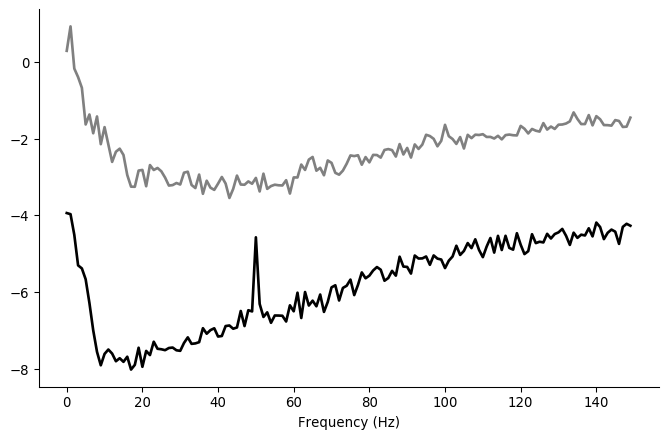

In [104]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'Postictal_norm' + '_comparison.png'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(postictal_dic['SD_mean_normdb'], color='k', lw=2, label='SD')
ax.plot(postictal_dic['nonSD_mean_normdb'], color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
#ax.set_ylabel('Power (db)')
#ax.set_ylabel(f'10*log10(preictal/baseline)')
#ax.set_title('Postictal norm')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend()
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.savefig(os.path.join(saveplot_path, figname), format='png', dpi=600, transparent=True)

plt.show()

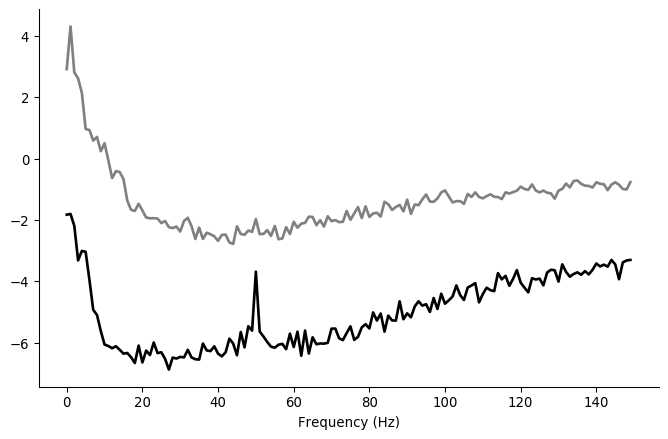

In [105]:
#saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_psd/'
figname = 'pospre_diff_normdb.png'

my_dpi = 96
fig, ax = plt.subplots(figsize=(800/my_dpi, 500/my_dpi), dpi=my_dpi,sharex=True, sharey=True)
ax.plot(np.subtract(postictal_dic['SD_mean_normdb'],preictal_dic['SD_mean_normdb']), color='k', lw=2, label='SD')
ax.plot(np.subtract(postictal_dic['nonSD_mean_normdb'], preictal_dic['nonSD_mean_normdb']), color='gray', lw=2, label='non SD')

ax.set_xlabel('Frequency (Hz)')
#ax.set_ylabel('delta post-preictal, dB')
#ax.set_ylabel(f'10*log10(period/baseline)')
#ax.set_title('pospre_diff_normdb')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend()
saveplot_path = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
#plt.savefig(os.path.join(saveplot_path, figname), format='eps', dpi=my_dpi)
plt.savefig(os.path.join(saveplot_path, figname), format='png', dpi=600, transparent=True)
plt.show()

_____

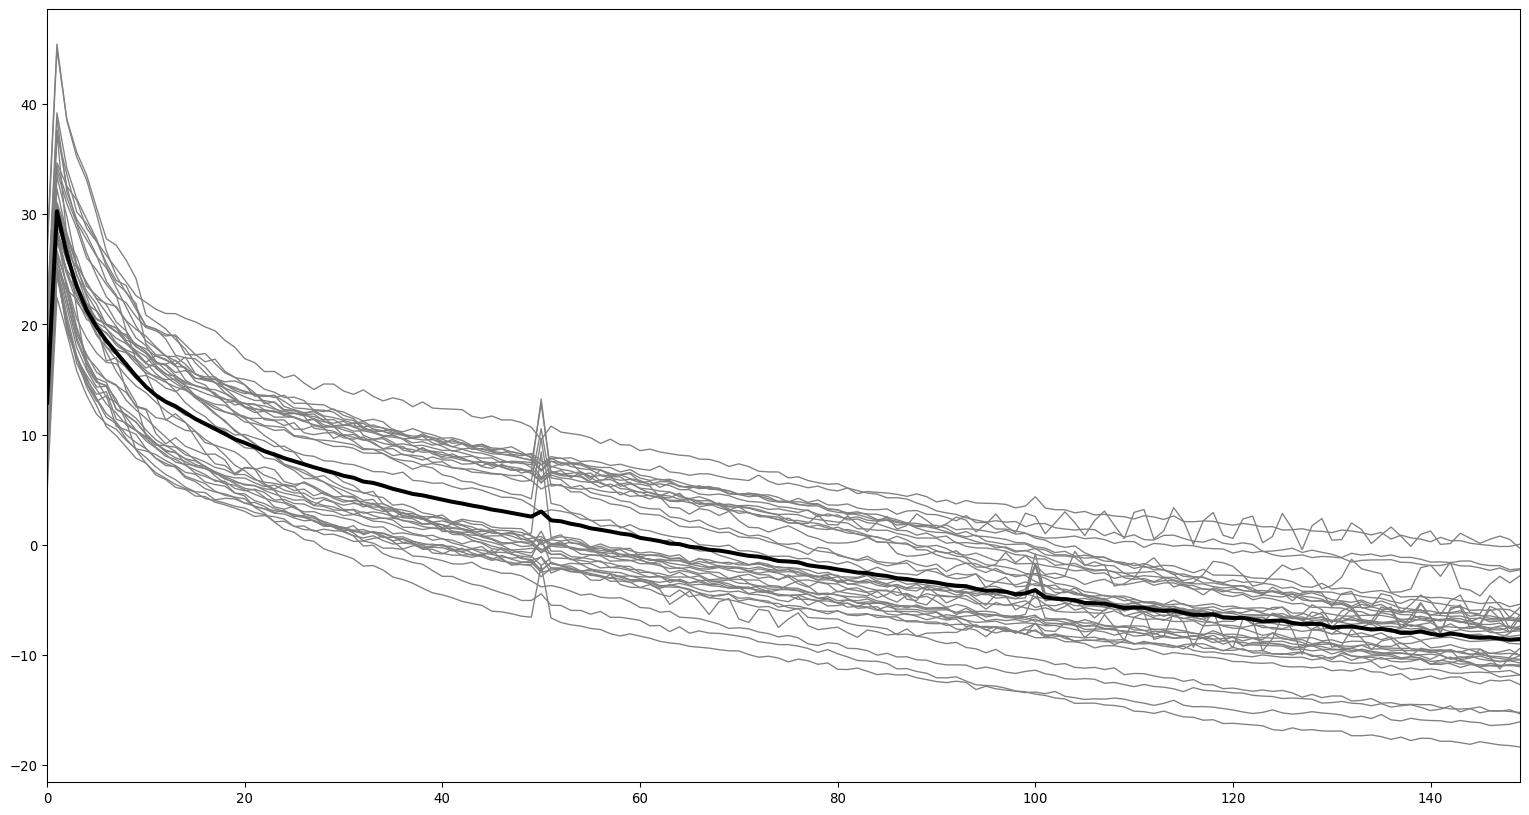

In [125]:

my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)

datamean = data_to_plot.mean(0)
datastd = data_to_plot.std(0)


for data in data_to_plot:
    ax.plot(data, color='gray', lw=1)
ax.plot(xax, datamean, 'k', lw=3)
#ax.plot(xax, datamean + datastd, color='gray', lw=1)
#ax.plot(xax, datamean - datastd, color='gray', lw=1)

ax.set_xlim((xax[0], xax[-1]))
plt.show()

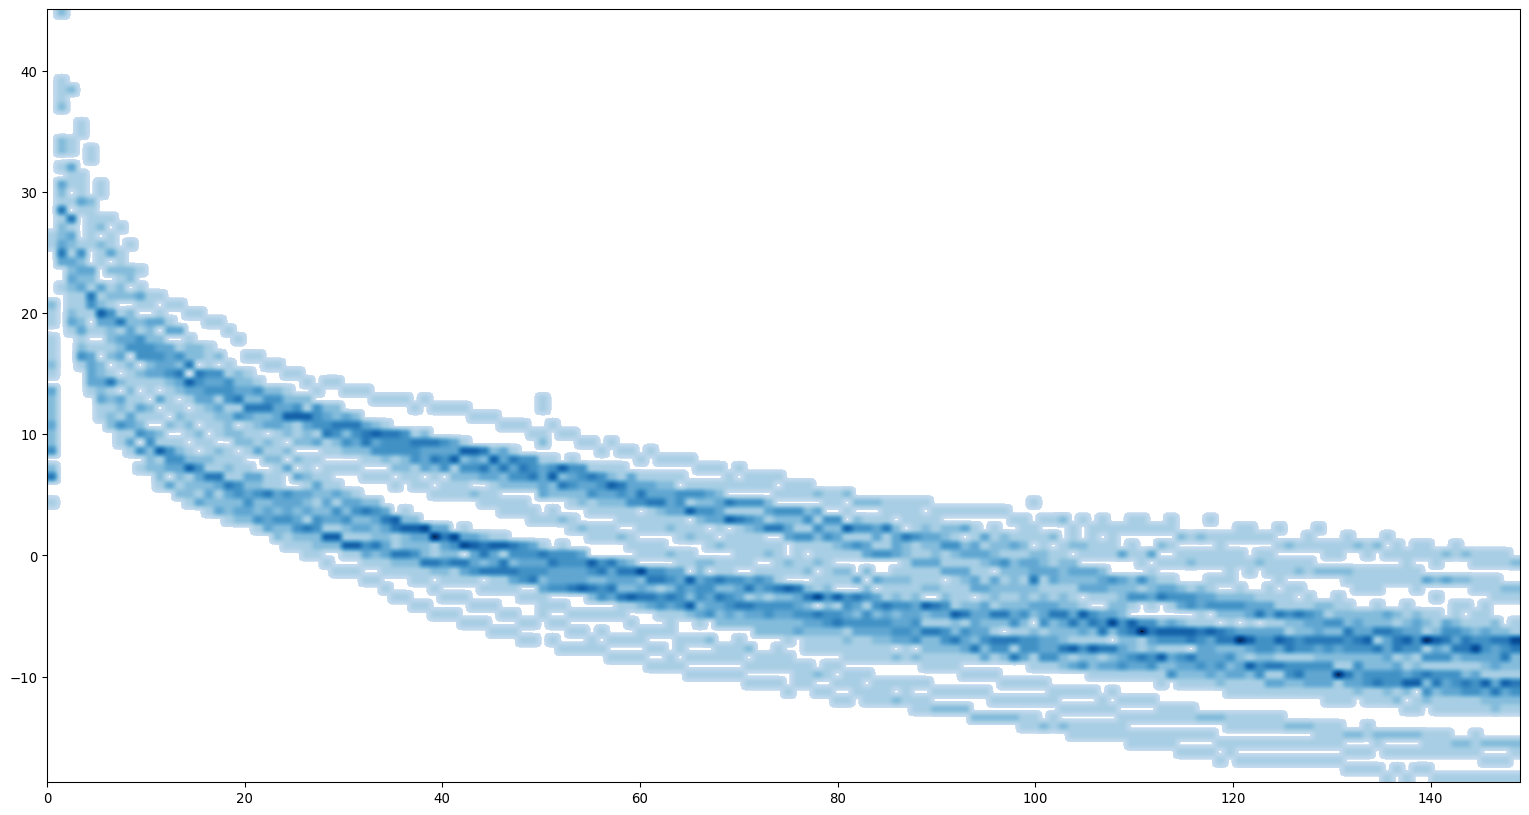

In [43]:
cmap = cm.Blues

# idea taken from http://stackoverflow.com/a/14779462
cmaplist = [cmap(i) for i in range(int(cmap.N/4), cmap.N)]
# set first color to white
cmaplist[0] = (1, 1, 1, 1)
# set last color to black
cmaplist[-1] = (0, 0, 0, 1)

cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
spDisplayBorder = 5  # µV additional border in display


def spike_heatmap(ax, spikes, x=None, log=False):
    """
    takes spikes, plots heatmap over samples and mean/std line
    """
    spMin = spikes.min()
    spMax = spikes.max()
    spBins = np.linspace(spMin, spMax, int(round(2*spMax)))
    if spBins.shape[0] < 3:
        spBins = np.linspace(spMin, spMax, 3)

    nSamp = spikes.shape[1]

    if x is None:
        x = range(nSamp)

    imdata = np.zeros((len(spBins) - 1, nSamp))

    for col in range(nSamp):
        data = np.histogram(spikes[:, col], bins=spBins)[0]
        if log:
            imdata[:, col] = np.log(1 + data)
        else:
            imdata[:, col] = data

    ydiff = (spBins[1] - spBins[0])/2.
    extent = [x[0], x[-1], spMin-ydiff, spMax-ydiff]

    ax.imshow(imdata,
              cmap=cmap,
              interpolation='hanning',
              aspect='auto',
              origin='lower',
              extent=extent)

    spMean = spikes.mean(0)
    spStd = spikes.std(0)

    ax.plot(x, spMean, 'k', lw=1)
    ax.plot(x, spMean + spStd, color=(.2, .2, .2), lw=1)